In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from transformers import AutoTokenizer, TFXLNetModel

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from scipy.stats import pearsonr

import joblib

import numpy as np
import pickle

pd.set_option('display.max_colwidth', 50)


In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [3]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_preprocessed_dataset_portuguese.csv')#.sample(10000).reset_index(drop='index')
df.head()

,Text,Source,URL,Label,text_preprocessed,count_words_text,num_nouns_text,num_verbs_text,num_adj_text,num_adv_text,sentiment_avg_text,features
0,PJ em operação internacional de tráfico de dro...,DN,https://www.dn.pt/sociedade/pj-em-operacao-int...,1,PJ operação internacional tráfico droga apreen...,206,42,28,15,5,-0.7351,PJ operação internacional tráfico droga apreen...
1,O texto foi criado - numa universidade da Repú...,NaN,https://poligrafo.sapo.pt/fact-check/fact-chec...,1,texto criar - universidade República Checa - s...,130,40,22,13,1,0.0000,texto criar - universidade República Checa - s...
2,Nunca pague multas por conduzir sem carta ou s...,Contas Poupança,https://arquivo.pt/wayback/20200626170105mp_/h...,0,nunca paguar multa conduzir carta Cartão Cidad...,306,81,69,32,19,0.1677,nunca paguar multa conduzir carta Cartão Cidad...
3,"Depois de António Guterres, uma estátua de D. ...",redes sociais,https://poligrafo.sapo.pt/fact-check/fact-chec...,0,"António Guterres , estátua D. Afonso Henriques...",164,29,21,11,3,0.0000,"António Guterres , estátua D. Afonso Henriques..."
4,"O MAR, uma droga gratuita que cura pelo menos ...",Coruja,https://arquivo.pt/wayback/20181012145922mp_/h...,0,"MAR , droga gratuito cura menos 16 DOENÇAS ! F...",538,191,66,105,24,0.5093,"MAR , droga gratuito cura menos 16 DOENÇAS ! F..."


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

X = df['text_preprocessed']
y = df['Label']

#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)

X_train_seq.shape[1]

Train vocabulary size: 113213


512

Simple DNN Model

In [6]:
# # Step 1: Load and preprocess your dataset (replace 'df' and 'labels' with your actual data)
# # For this example, let's assume you have a DataFrame 'df' with a 'text' column and a 'label' column (0 for fake, 1 for real).
# X = df['Text']
# y = df['Label']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 2: Tokenize the text data
# #max_words = 10000  # Maximum number of words to keep in the vocabulary
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)

# # Convert text to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# # Pad sequences to ensure consistent input shape
# max_sequence_length = 100  # Choose an appropriate sequence length
# X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
# X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [6]:
# Step 3: Build and train the DNN model
model = Sequential()
model.add(Embedding(input_dim = len(tok.word_index), output_dim=128, input_length=MAX_LEN))#model.add(Embedding(input_dim = len(tok.word_index), output_dim=128, input_length=max_sequence_length))
model.add(Flatten())  # You can also use LSTM or other recurrent layers here
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq,#X_train_padded,
          y_train,
          epochs=20,
          batch_size=64,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)])

Epoch 1/20
593/593 [==============================] - 17s 26ms/step - loss: 0.2683 - accuracy: 0.8802 - val_loss: 0.1873 - val_accuracy: 0.9252
Epoch 2/20
593/593 [==============================] - 16s 26ms/step - loss: 0.0486 - accuracy: 0.9839 - val_loss: 0.2337 - val_accuracy: 0.9204
Epoch 3/20
593/593 [==============================] - 14s 23ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.2919 - val_accuracy: 0.9209
Epoch 4/20
593/593 [==============================] - 14s 23ms/step - loss: 4.2167e-04 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 0.9202


495/495 [==============================] - 1s 3ms/step - loss: 0.1900 - accuracy: 0.9243
Test Loss: 0.18995346128940582
Test Accuracy: 0.9242836236953735


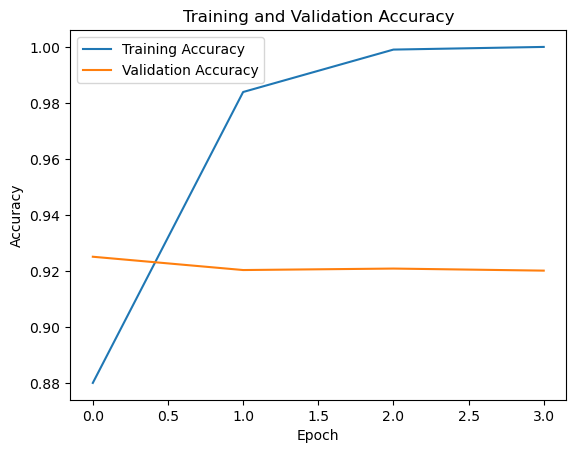

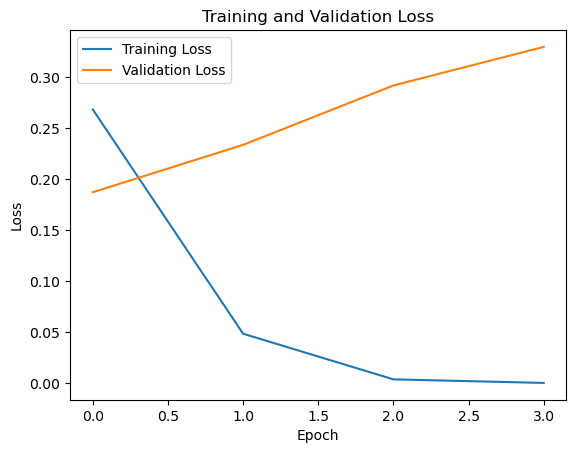

In [7]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

In [8]:
# Step 4: Model Evaluation
y_pred = model.predict(X_test_seq)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7880
           1       0.93      0.92      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



CNN Simple

In [14]:
# Step 3: Build and train the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tok.word_index), output_dim=128, input_length=MAX_LEN))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_seq,
          y_train,
          epochs=20,
          batch_size=64,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# Step 4: Model Evaluation
y_pred = model.predict(X_test_seq)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/20
593/593 [==============================] - 26s 37ms/step - loss: 0.2567 - accuracy: 0.8897 - val_loss: 0.1925 - val_accuracy: 0.9208
Epoch 2/20
593/593 [==============================] - 21s 36ms/step - loss: 0.0901 - accuracy: 0.9675 - val_loss: 0.2095 - val_accuracy: 0.9216
Epoch 3/20
593/593 [==============================] - 21s 36ms/step - loss: 0.0217 - accuracy: 0.9921 - val_loss: 0.3542 - val_accuracy: 0.9233
Epoch 4/20
593/593 [==============================] - 21s 36ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.4296 - val_accuracy: 0.9130
Epoch 5/20
593/593 [==============================] - 21s 35ms/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.4447 - val_accuracy: 0.9068
Epoch 6/20
593/593 [==============================] - 22s 37ms/step - loss: 0.0070 - accuracy: 0.9973 - val_loss: 0.5647 - val_accuracy: 0.9192
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7880
           1       0.93    

Simple LSTM Model

In [9]:
# Define the model
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)])
                    

Epoch 1/20
593/593 [==============================] - 86s 138ms/step - loss: 0.3508 - accuracy: 0.8491 - val_loss: 0.2293 - val_accuracy: 0.9094
Epoch 2/20
593/593 [==============================] - 77s 129ms/step - loss: 0.1859 - accuracy: 0.9334 - val_loss: 0.2272 - val_accuracy: 0.9185
Epoch 3/20
593/593 [==============================] - 76s 128ms/step - loss: 0.1251 - accuracy: 0.9589 - val_loss: 0.2267 - val_accuracy: 0.9201
Epoch 4/20
593/593 [==============================] - 76s 128ms/step - loss: 0.0810 - accuracy: 0.9747 - val_loss: 0.2522 - val_accuracy: 0.9143
Epoch 5/20
593/593 [==============================] - 86s 145ms/step - loss: 0.0562 - accuracy: 0.9830 - val_loss: 0.3204 - val_accuracy: 0.9121
Epoch 6/20
593/593 [==============================] - 85s 143ms/step - loss: 0.0418 - accuracy: 0.9876 - val_loss: 0.4010 - val_accuracy: 0.9082


495/495 [==============================] - 18s 36ms/step - loss: 0.2269 - accuracy: 0.9173
Test Loss: 0.2269296944141388
Test Accuracy: 0.9172623157501221


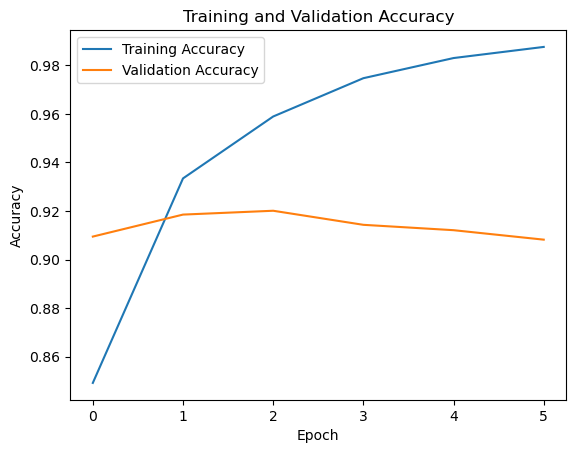

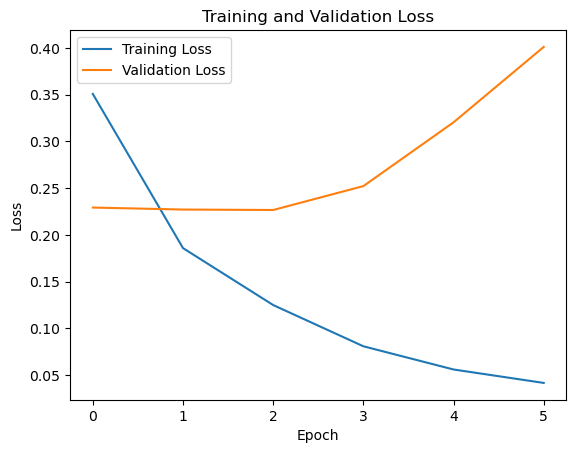

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7880
           1       0.91      0.93      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

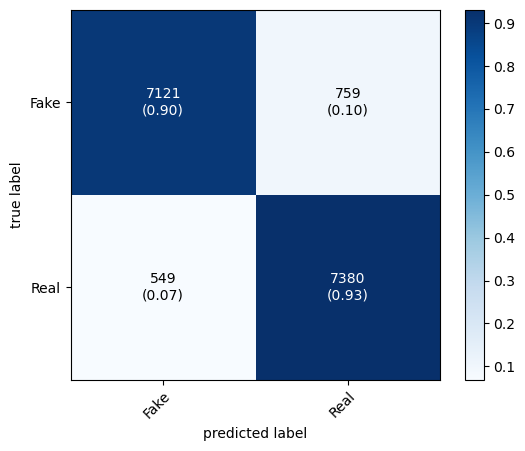

In [11]:
# print classification report
y_hat = model.predict(X_test_seq)
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

Simple Bi-LSTM Model

Epoch 1/20
593/593 [==============================] - 152s 251ms/step - loss: 0.3592 - accuracy: 0.8386 - val_loss: 0.2283 - val_accuracy: 0.9127
Epoch 2/20
593/593 [==============================] - 150s 253ms/step - loss: 0.1714 - accuracy: 0.9373 - val_loss: 0.2378 - val_accuracy: 0.9131
Epoch 3/20
593/593 [==============================] - 153s 258ms/step - loss: 0.1021 - accuracy: 0.9658 - val_loss: 0.2269 - val_accuracy: 0.9174
Epoch 4/20
593/593 [==============================] - 159s 268ms/step - loss: 0.0562 - accuracy: 0.9827 - val_loss: 0.2968 - val_accuracy: 0.9111
Epoch 5/20
593/593 [==============================] - 163s 276ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 0.3396 - val_accuracy: 0.9123
Epoch 6/20
593/593 [==============================] - 159s 268ms/step - loss: 0.0251 - accuracy: 0.9938 - val_loss: 0.3914 - val_accuracy: 0.9068


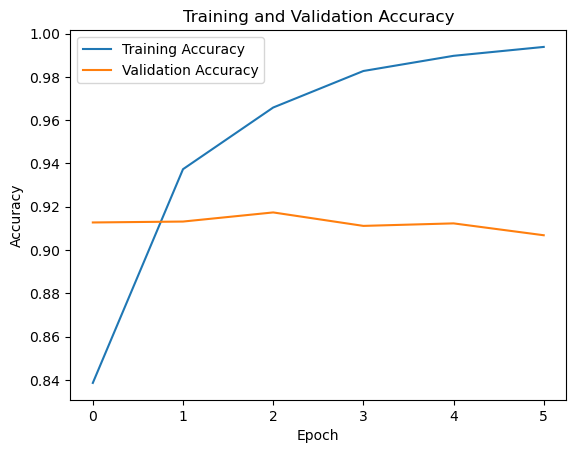

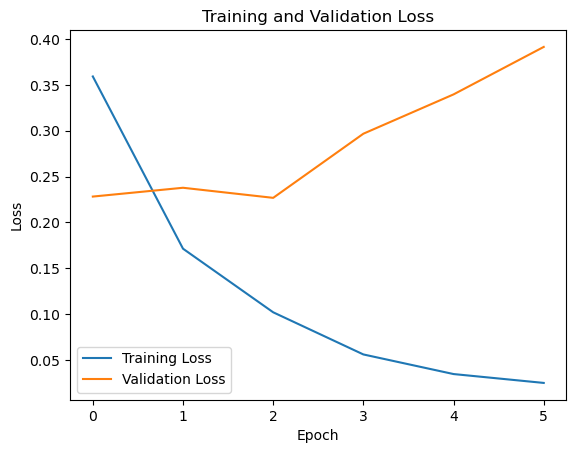

In [12]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
# model.summary()

#Fit the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split = 0.2,
                    batch_size = 64,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot validation curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

495/495 [==============================] - 44s 88ms/step - loss: 0.2214 - accuracy: 0.9200
Test Loss: 0.22143657505512238
Test Accuracy: 0.9199823141098022
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7880
           1       0.91      0.93      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

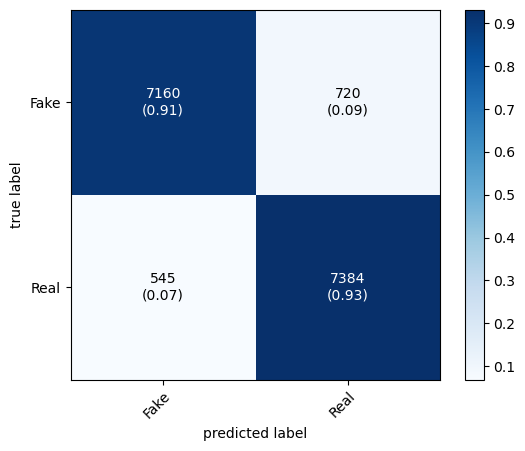

In [13]:
from mlxtend.plotting import plot_confusion_matrix

#Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

BERT (with only text)

In [6]:
# Split data into train and test sets
X = df['text_preprocessed'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Load tokenized data
# with open('X_train_tokenized_BERT_uncased.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_test_tokenized_BERT_uncased.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [7]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
317/317 [==============================] - 443s 1s/step - loss: 1.0380 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 2/20
317/317 [==============================] - 406s 1s/step - loss: 0.6935 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 3/20
317/317 [==============================] - 404s 1s/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 4/20
99/99 [==============================] - 94s 941ms/step - loss: 0.6931 - accuracy: 0.5031
Test loss: 0.693, Test accuracy: 0.503


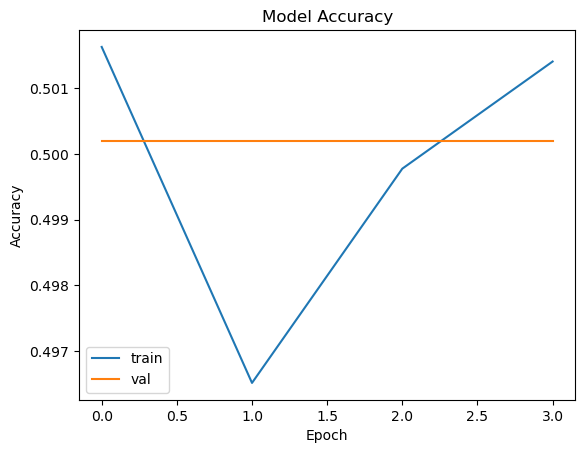

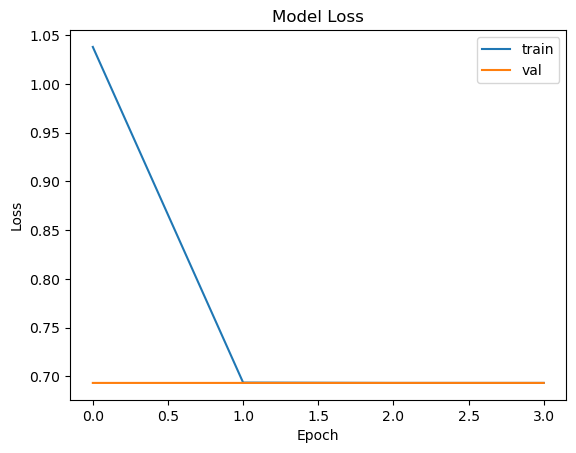

In [8]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6285
           1       0.50      1.00      0.67      6363

    accuracy                           0.50     12648
   macro avg       0.25      0.50      0.33     12648
weighted avg       0.25      0.50      0.34     12648



c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

RoBERTa with only text

In [5]:
# Split data into train and test sets
X = df['text_preprocessed'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
# with open('X_train_tokenized_roBERTa_base.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_roBERTa_base.pkl', 'wb') as f:
#    pickle.dump(X_test_tokenized, f)

# Load tokenized data
# with open('X_train_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_test_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
roberta_model = TFBertModel.from_pretrained('roberta-base')

# Freeze the pre-trained layers
for layer in roberta_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = roberta_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at roberta-base were not used when initializing TFBertModel: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
317/317 [==============================] - 429s 1s/step - loss: 1.7592 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 2/20
317/317 [==============================] - 406s 1s/step - loss: 0.6937 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 3/20
317/317 [==============================] - 404s 1s/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 4/20
317/317 [==============================] - 406s 1s/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 5/20
317/317 [==============================] - 408s 1s/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 6/20
99/99 [==============================] - 94s 941ms/step - loss: 0.6931 - accuracy: 0.5031
Test loss: 0.693, Test accuracy: 0.503


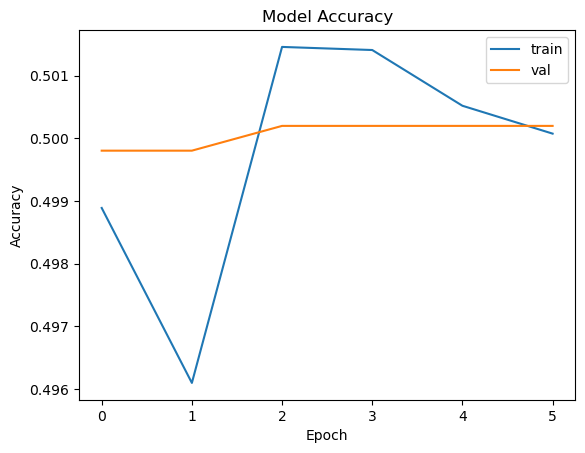

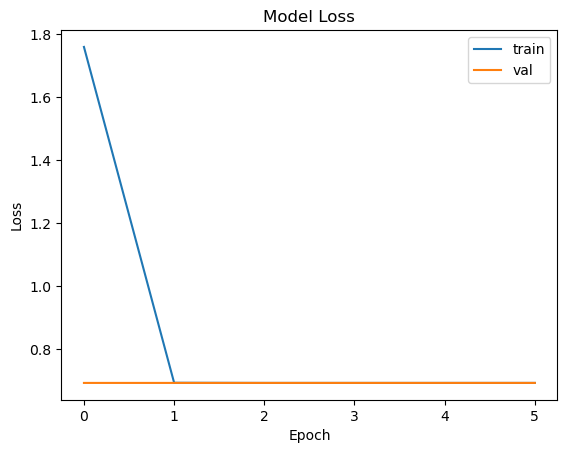

In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6285
           1       0.50      1.00      0.67      6363

    accuracy                           0.50     12648
   macro avg       0.25      0.50      0.33     12648
weighted avg       0.25      0.50      0.34     12648



c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

XLNET (with only text)

In [5]:
# Split data into train and test sets
X = df['text_preprocessed'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# # Save tokenized data
# with open('X_train_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
# with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
model = TFXLNetModel.from_pretrained("xlnet-base-cased")

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=16,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

Epoch 1/20
2530/2530 [==============================] - 1053s 414ms/step - loss: 0.8030 - accuracy: 0.7847 - val_loss: 0.4235 - val_accuracy: 0.8077
Epoch 2/20
2530/2530 [==============================] - 1027s 406ms/step - loss: 0.3679 - accuracy: 0.8302 - val_loss: 0.3391 - val_accuracy: 0.8459
Epoch 3/20
2530/2530 [==============================] - 1034s 409ms/step - loss: 0.3344 - accuracy: 0.8468 - val_loss: 0.3499 - val_accuracy: 0.8412
Epoch 4/20
2530/2530 [==============================] - 1067s 422ms/step - loss: 0.3133 - accuracy: 0.8581 - val_loss: 0.3426 - val_accuracy: 0.8382
Epoch 5/20
2530/2530 [==============================] - 1032s 408ms/step - loss: 0.2997 - accuracy: 0.8636 - val_loss: 0.3414 - val_accuracy: 0.8544
Epoch 6/20
2530/2530 [==============================] - 1038s 410ms/step - loss: 0.2843 - accuracy: 0.8726 - val_loss: 0.5047 - val_accuracy: 0.8047
Epoch 7/20
2530/2530 [==============================] - 1052s 416ms/step - loss: 0.2712 - accuracy: 0.8771

791/791 [==============================] - 137s 173ms/step - loss: 0.3436 - accuracy: 0.8676 - loss: 0.3423 - accura
Test loss: 0.344, Test accuracy: 0.868


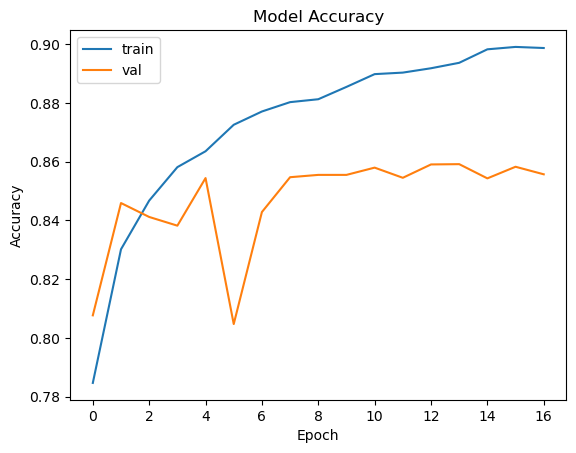

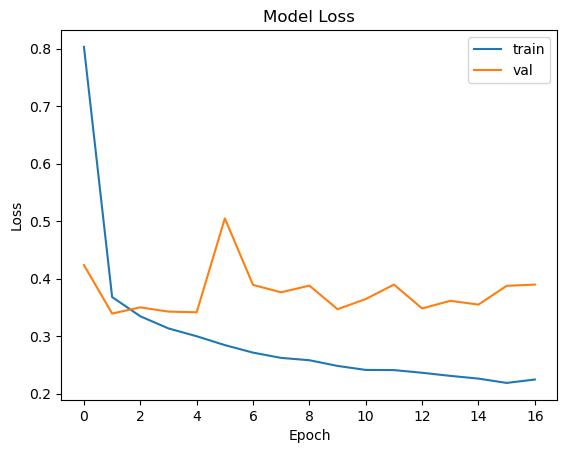

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=16)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6285
           1       0.87      0.86      0.87      6363

    accuracy                           0.87     12648
   macro avg       0.87      0.87      0.87     12648
weighted avg       0.87      0.87      0.87     12648



BERT Multilingual (only text)

In [5]:
# Split the dataset into train and test sets
X = df['text_preprocessed'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# # Tokenize the input texts
# X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
# X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# # Save tokenized data
# with open('X_train_tokenized_BERTmulti_base_prepro_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_BERTmulti_prepro_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_BERTmulti_base_prepro_cased.pkl', 'rb') as f:
    X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_BERTmulti_prepro_base_cased.pkl', 'rb') as f:
    X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained mBERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained mBERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
317/317 [==============================] - 444s 1s/step - loss: 0.7147 - accuracy: 0.7983 - val_loss: 0.4646 - val_accuracy: 0.8505
Epoch 2/10
317/317 [==============================] - 431s 1s/step - loss: 0.2910 - accuracy: 0.8806 - val_loss: 0.2805 - val_accuracy: 0.8732
Epoch 3/10
317/317 [==============================] - 409s 1s/step - loss: 0.1925 - accuracy: 0.9109 - val_loss: 0.2781 - val_accuracy: 0.8806
Epoch 4/10
317/317 [==============================] - 409s 1s/step - loss: 0.1636 - accuracy: 0.9189 - val_loss: 0.3210 - val_accuracy: 0.8801
Epoch 5/10
317/317 [==============================] - 403s 1s/step - loss: 0.1313 - accuracy: 0.9370 - val_loss: 0.3503 - val_accuracy: 0.8805
Epoch 6/10
99/99 [==============================] - 93s 942ms/step - loss: 0.2729 - accuracy: 0.8815
Test loss: 0.273, Test accuracy: 0.881


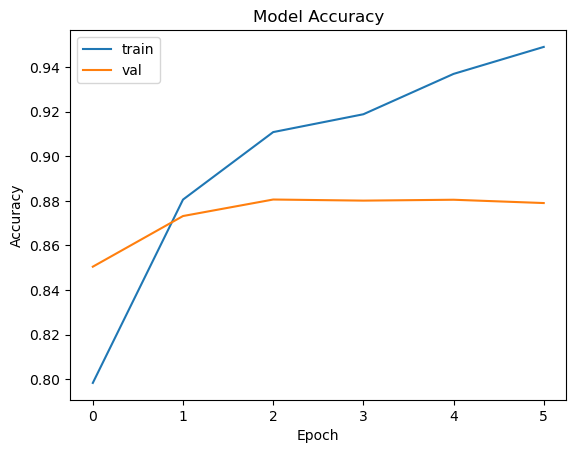

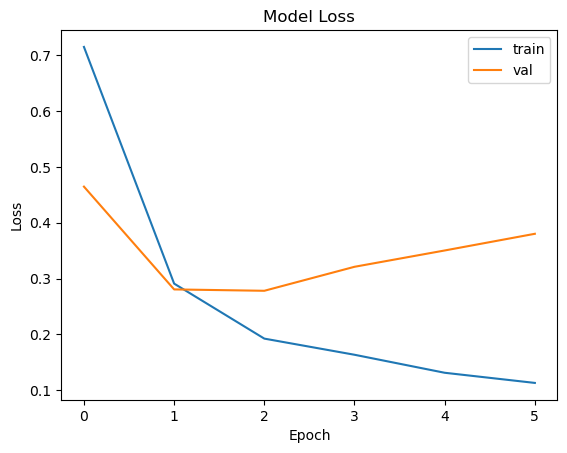

In [7]:
# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=128,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87      6285
           1       0.84      0.95      0.89      6363

    accuracy                           0.88     12648
   macro avg       0.89      0.88      0.88     12648
weighted avg       0.89      0.88      0.88     12648

